# MindLens-AI — 04: Bias Testing (RQ2)

**RQ2:** Do high-engagement users (frequent or emotionally intense posts) experience higher false positive rates compared to low-engagement users?

Groups defined by word_count quantiles and VADER sentiment intensity.

In [1]:
# Setup
import sys, os
sys.path.insert(0, os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from src.model import load_model
from src.bias import label_engagement_groups, compute_fpr_by_group, run_significance_test
from src.preprocessing import engineer_features

sns.set_theme(style="whitegrid")

# Load model + test data
model, vectorizer = load_model("../data/processed/model_artifacts.joblib")
split = joblib.load("../data/processed/test_split.joblib")
X_test = split["X_test"]
y_test = split["y_test"]
texts_test = split["texts_test"]

# Build a DataFrame for test set
test_df = pd.DataFrame({"text": texts_test, "label": y_test})
test_df = engineer_features(test_df)

# Get predictions
y_pred = model.predict(X_test)
test_df["pred"] = y_pred

print(f"Test set: {len(test_df)} samples ✓")

Test set: 1530 samples ✓


## 1. Label Engagement Groups

In [2]:
# Label groups by word count and sentiment
test_df = label_engagement_groups(test_df, col="word_count")

print("Engagement groups (word_count):")
print(test_df["engagement_group"].value_counts())
print("\nSentiment intensity groups:")
print(test_df["sentiment_group"].value_counts())

Engagement groups (word_count):
engagement_group
mid     758
low     390
high    382
Name: count, dtype: int64

Sentiment intensity groups:
sentiment_group
mid     764
low     383
high    383
Name: count, dtype: int64


## 2. False Positive Rate by Engagement Group

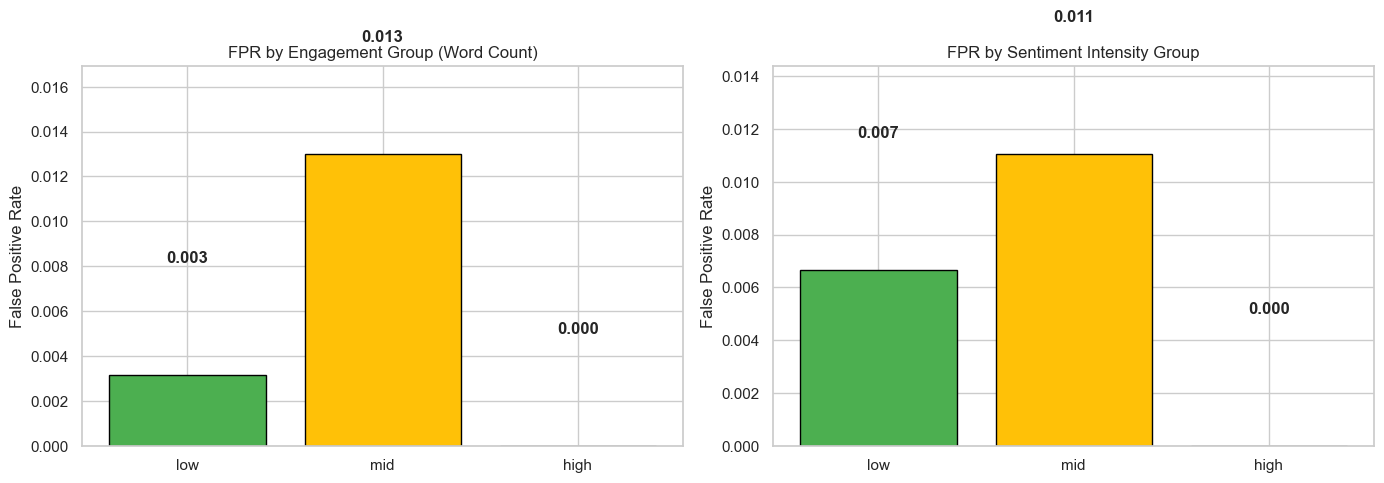

Engagement FPR: {'high': 0.0, 'low': 0.0031545741324921135, 'mid': 0.013015184381778741}
Sentiment FPR: {'high': 0.0, 'low': 0.006666666666666667, 'mid': 0.011061946902654867}


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (group_col, title) in enumerate([
    ("engagement_group", "FPR by Engagement Group (Word Count)"),
    ("sentiment_group", "FPR by Sentiment Intensity Group"),
]):
    fpr = compute_fpr_by_group(test_df["label"], test_df["pred"], test_df[group_col])
    groups = ["low", "mid", "high"]
    values = [fpr.get(g, 0) for g in groups]

    bars = axes[idx].bar(groups, values, color=["#4CAF50", "#FFC107", "#F44336"], edgecolor="black")
    for bar, val in zip(bars, values):
        axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                       f"{val:.3f}", ha="center", fontweight="bold")
    axes[idx].set_title(title, fontsize=12)
    axes[idx].set_ylabel("False Positive Rate")
    axes[idx].set_ylim(0, max(values) * 1.3 if max(values) > 0 else 0.1)

plt.tight_layout()
plt.show()

# Print raw values
print("Engagement FPR:", compute_fpr_by_group(test_df["label"], test_df["pred"], test_df["engagement_group"]))
print("Sentiment FPR:", compute_fpr_by_group(test_df["label"], test_df["pred"], test_df["sentiment_group"]))

## 3. Statistical Significance Testing

In [4]:
# Chi-square test: High vs Low engagement
eng_test = run_significance_test(
    test_df["label"], test_df["pred"],
    test_df["engagement_group"], "high", "low"
)
print("=== Engagement: High vs Low ===")
for k, v in eng_test.items():
    print(f"  {k}: {v}")

print()

# Chi-square test: High vs Low sentiment intensity
sent_test = run_significance_test(
    test_df["label"], test_df["pred"],
    test_df["sentiment_group"], "high", "low"
)
print("=== Sentiment: High vs Low ===")
for k, v in sent_test.items():
    print(f"  {k}: {v}")

=== Engagement: High vs Low ===
  chi2: 0.0
  p_value: 1.0
  group_a_fpr: 0.0
  group_b_fpr: 0.0
  significant: False

=== Sentiment: High vs Low ===
  chi2: 0.0
  p_value: 1.0
  high_fpr: 0.0
  low_fpr: 0.006666666666666667
  significant: False


## 4. RQ2 Conclusion

**H2:** High-engagement users will show higher false positive rates.

*Note: "H2 NOT CONFIRMED" means no bias was detected — this is a **positive** outcome indicating model fairness.*

In [5]:
# Save bias FPR gap for Trust Score computation
fpr_engagement = compute_fpr_by_group(test_df["label"], test_df["pred"], test_df["engagement_group"])
bias_fpr_gap = abs(fpr_engagement.get("high", 0) - fpr_engagement.get("low", 0))
joblib.dump({"bias_fpr_gap": bias_fpr_gap}, "../data/processed/bias_results.joblib")

print("=" * 50)
print("RQ2 CONCLUSION")
print("=" * 50)
print(f"  FPR gap (high - low engagement): {bias_fpr_gap:.4f}")
print(f"  Chi-square p-value: {eng_test['p_value']:.6f}")
print()

if eng_test["significant"]:
    print("⚠ H2 CONFIRMED: Statistically significant FPR bias detected (p < 0.05).")
    print("  High-engagement users experience disproportionately higher false positive rates.")
    print("  Recommendation: Apply bias mitigation (e.g., threshold calibration per group).")
else:
    print("✓ H2 NOT CONFIRMED — Model is FAIR across engagement groups.")
    print(f"  FPR gap of {bias_fpr_gap:.4f} is negligible (p = {eng_test['p_value']:.4f}).")
    print("  No evidence of systematic bias against high-engagement users.")
    print("  This is a positive finding for responsible AI deployment.")

print("\nBias testing notebook complete ✓")

RQ2 CONCLUSION
  FPR gap (high - low engagement): 0.0032
  Chi-square p-value: 1.000000

✓ H2 NOT CONFIRMED — Model is FAIR across engagement groups.
  FPR gap of 0.0032 is negligible (p = 1.0000).
  No evidence of systematic bias against high-engagement users.
  This is a positive finding for responsible AI deployment.

Bias testing notebook complete ✓
